In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
from numba import jit, njit, prange
from sympy import isprime, primerange
from sympy.utilities.iterables import multiset_permutations
from tqdm import tqdm_notebook as tqdm
from sklearn.neighbors import KDTree

np.random.seed(seed=42)
df = pd.read_csv('1515602.86080513.csv')
#df = pd.read_csv('submission17.csv')
cities = pd.read_csv('input/cities.csv')

In [2]:
primes = np.array(list(primerange(0, len(cities))))
is_prime = np.array([0 if not isprime(i) else 1 for i in cities.index]) 
complexes = (cities.X + 1j * cities.Y).values
XY = np.array([cities.X.values, cities.Y.values]).T
path = df.Path.values
tree = KDTree(XY, 5)
# k = 3
# i = path[1]
# dist, ind = tree.query(XY[i:i+1], k=k+1)
# print(dist[0][1:])
# print(ind[0][1:])

[primes.shape, complexes.shape, path.shape, XY.shape]

[(17802,), (197769,), (197770,), (197769, 2)]

In [3]:
# def dist2(a, b):
#     return (np.sum((XY[b] - XY[a])**2))**0.5
# dist2(path[0], path[1])

In [4]:
def dist(a, b):
    return np.abs(complexes[a] - complexes[b])

In [243]:
@jit('i8(i8)')
def closest_prime(base_index):
    min_dist = np.inf
    closest_index = -1
    for i in primes:
        d = np.abs(complexes[base_index] - complexes[i])
        if d < min_dist and i != base_index:
            min_dist = d
            closest_index = i
    return closest_index

In [13]:
@jit('f4(i4[:], i4, i4)')
def score_between(path, a, b):
    c = np.array(complexes[path[a: b+1]])
    sc = np.sum(np.abs(np.diff(c)))
    pn = 0
#     for i in range(a+1, b+1):
#         if i % 10 == 0:
#             if is_prime[path[i-1]] == False:
#                 pn += np.abs(complexes[path[i-1]] - complexes[path[i]]) * 0.1
    return sc + pn

score_between(path, 0, len(path)-1)

1503333.384922245

In [277]:
def opt_prime(path):
    sum1 = 0
    sum2 = 0
    for i in tqdm(range(0, len(path), 10)):
        if i > 0:
            p = is_prime[path[i-1]]
            if p == False:
                closest_prime_index = closest_prime(path[i]) # i-2 / i
                closest_prime_path_index = np.where(path==closest_prime_index)[0][0]
                if closest_prime_path_index < i-1:
                    s1 = score_between(path, closest_prime_path_index-1, i)
                    path_copy = np.insert(path, i, closest_prime_index)
                    path_copy = np.delete(path_copy, closest_prime_path_index)
                    s2 = score_between(path_copy, closest_prime_path_index-1, i)
                    if s1 > s2:
                        sum1 += 1
                        path = path_copy
                        print('sum1:', sum1, i, score_between(path, 0, len(path)-1))
                elif closest_prime_path_index > i-1:
                    s1 = score_between(path, i-2, closest_prime_path_index+1)
                    path_copy = np.insert(path, i-1, closest_prime_index)
                    path_copy = np.delete(path_copy, closest_prime_path_index+1)
                    s2 = score_between(path_copy, i-2, closest_prime_path_index+1)
                    if s1 > s2:
                        sum2 += 1
                        path = path_copy
                        print('sum2:', sum2, i, score_between(path, 0, len(path)-1))
    return path

In [283]:
path = opt_prime(path)
score_between(path, 0, len(path)-1)

1515595.022840546

In [217]:
def eval_path(path):
    copy = path[:-1].copy()
    copy.sort()
    cnt = 0
    for i in range(len(path)-1):
        if i != copy[i]:
            cnt += 1
            print(i, 'missing')
            break
    del copy
    print('End:', cnt, 'missing: ',score_between(path, 0, len(path)-1))

eval_path(path) 

End: 0 missing:  1515602.8889715623


In [242]:
def eval_prime(path):
    cnt = 0
    for i in range(len(path)-1):
        if i % 10 == 9 and isprime(i):
            cnt += 1
    print('Primes: ', cnt)

eval_prime(path)

Primes:  4439


In [289]:
def closest_k(path, k):
    c = np.array([tree.query(XY[path[i:i+1]], k=k+1)[1][0] for i in tqdm(range(len(path)-1))])
    return c[:, 1:k+1]

#@jit #(parallel=True)
def opt_k(path, k):
    print('Initial Score: ', score_between(path, 0, len(path)-1))
    print('Creating Permutations:')
    perms = closest_k(path, k)

    for i in tqdm(range(len(perms)-1)):
    #for i in tqdm(prange(1, 1000)):
        sc1 = score_between(path, 0, len(path)-1)
        combs = np.array(list(multiset_permutations(perms[i])))
        sc3 = np.inf
        for comb in combs:
            if not 0 in comb:
                copy = path.copy()
                copy = np.delete(copy, np.array([np.where(path==c) for c in comb]))
                copy = np.insert(copy, i, comb)
                sc2 = score_between(copy, 0, len(path)-1)
                if sc1 > sc2:
                    if sc3 > sc2:
                        sc3 = sc2
                        path = copy.copy()
                        print(len(path), i, score_between(path, 0, len(path)-1))
    return path
score_between(path, 0, len(path)-1)

1515595.022840546

In [ ]:
path = opt_k(path, 3)

In [74]:
eval_path(path)

End: 0 1724934.3273185876


In [279]:
#@jit(parallel=True)
def opt_n(path, n):
    for i in tqdm(range(1, len(path)-n-1)):
    #for i in tqdm(prange(1, len(path)//10)):
        perm = np.array([path[i+n] for n in range(n)])
        combs = np.array(list(multiset_permutations(perm)))
        new_combs = np.array([p for p in combs if p[0] != perm[0] and p[-1] != perm[-1]])
        sc1 = score_between(path, i-1, i+n+1)
        sc3 = np.inf
        for comb in new_combs:
        #for comb in combs:
            copy = np.concatenate([path[:i], comb, path[i+n:]])
            sc2 = score_between(copy, i-1, i+n+1)
            if sc1 > sc2:
                if sc3 > sc2:
                    sc3 = sc2
                    path = copy.copy()
                    print(i, score_between(path, 0, len(path)-1))

    return path

In [284]:
path = opt_n(path, 4) # 3:1m48s, 4:6m, 5:37m, 6:5h, 7:21h
score_between(path, 0, len(path)-1)

1515595.022840546

In [14]:
@jit('i4[:](i4[:], i4)', parallel=True)
def opt_n_flip(path, n):
    for i in tqdm(range(n, len(path)-n-1)):
        n1 = i
        n2 = n1 + n
        sc1 = score_between(path, n1-1, n2+1)
        rev = path[n1: n2+1][::-1]
        copy = np.concatenate([path[:n1], rev, path[n2+1:]])
        sc2 = score_between(copy, n1-1, n2+1)
        if sc1 > sc2:
            path = copy.copy()
            print(score_between(path, 0, len(path)-1))
    return path

@jit('i4[:](i4[:], i4)', parallel=True)
def opt_flip_loop(path, num):
    for n in tqdm(prange(0, num)): 
        path = opt_n_flip(path, n) # i=1: 25s, 10:250s, 100:2500s=56m, 1000:25000s=7h
    return path

In [ ]:
path = opt_flip_loop(path, len(path)-1)
print(score_between(path, 0, len(path)-1))

1503333.3050591177
1503333.2736203098
1503332.773321658
1503332.7045096764
1503332.3040030848
1503332.1905035127
1503331.0578259884
1503330.6176401298
1503330.4733143812
1503330.4533943795
1503330.4435495588
1503329.2699524274
1503328.7311587604
1503328.1069886535
1503322.767506769
1503322.7023594268
1503322.6752216157
1503322.6016090114
1503322.3600408656
1503321.8740509043
1503321.794624608
1503321.7331086923
1503321.1626872087
1503320.7416132523
1503320.614953538
1503320.2376071182


In [282]:
pd.DataFrame({'Path': path}).to_csv('submission.csv', index=False)

In [227]:
# flip it: https://www.kaggle.com/matthewa313/flip-it

tour = path.tolist() #pd.read_csv('submission.csv')['Path'].tolist()
cities = pd.read_csv('input/cities.csv')

# Define a function for length of a path:
import numpy as np
from sympy import primerange
primes = list(primerange(0, len(cities)))
def score_tour(tour):
    # length of any given tour with primes calculation
    df = cities.reindex(tour + [0]).reset_index()
    df['prime'] = df.CityId.isin(primes).astype(int)
    df['dist'] = np.hypot(df.X - df.X.shift(-1), df.Y - df.Y.shift(-1))
    df['penalty'] = df['dist'][9::10] * (1 - df['prime'][9::10]) * 0.1
    return df.dist.sum() + df.penalty.sum()

# Let's take a look at our tour
print("Tour path (0-5):",tour[0:5])
# And the flipped tour looks like:
tourflip = tour[::-1]
print("Flipped tour path (0-5):", tourflip[0:5])
# The scores of our tours are:
print("Score of original tour:", score_tour(tour))
print("Score of flipped tour:", score_tour(tourflip))

# If the flipped tour is quicker, change our tour:
if score_tour(tourflip) < score_tour(tour):
    print("The total improvement was:", abs(score_tour(tourflip) - score_tour(tour)))
    tour = tourflip 
    print("The better of the original/flipped tour is:", tour[0:5])

#pd.DataFrame({'Path': list(tour)}).to_csv('submission.csv', index=False)

Tour path (0-5): [0, 47239, 177242, 167366, 38941]
Flipped tour path (0-5): [0, 78934, 111804, 52086, 18295]
Score of original tour: 1747784.5163161769
Score of flipped tour: 1748310.4729062847


In [63]:
from matplotlib.path import Path
def plot_path(path):
    coords = cities[['X', 'Y']].values
    ordered_coords = coords[np.array(path)]
    codes = [Path.MOVETO] * len(ordered_coords)
    path = Path(ordered_coords, codes)
    
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(111)
    xs, ys = zip(*ordered_coords)
    ax.plot(xs, ys,  lw=1., ms=10)
    plt.axis('off')
    
    north_pole = cities[cities.CityId==0]
    plt.scatter(north_pole.X, north_pole.Y, c='red', s=10)
    
    n = 127560
    plt.scatter(cities.X[n], cities.Y[n], c='m', s=50)
    
    plt.show()


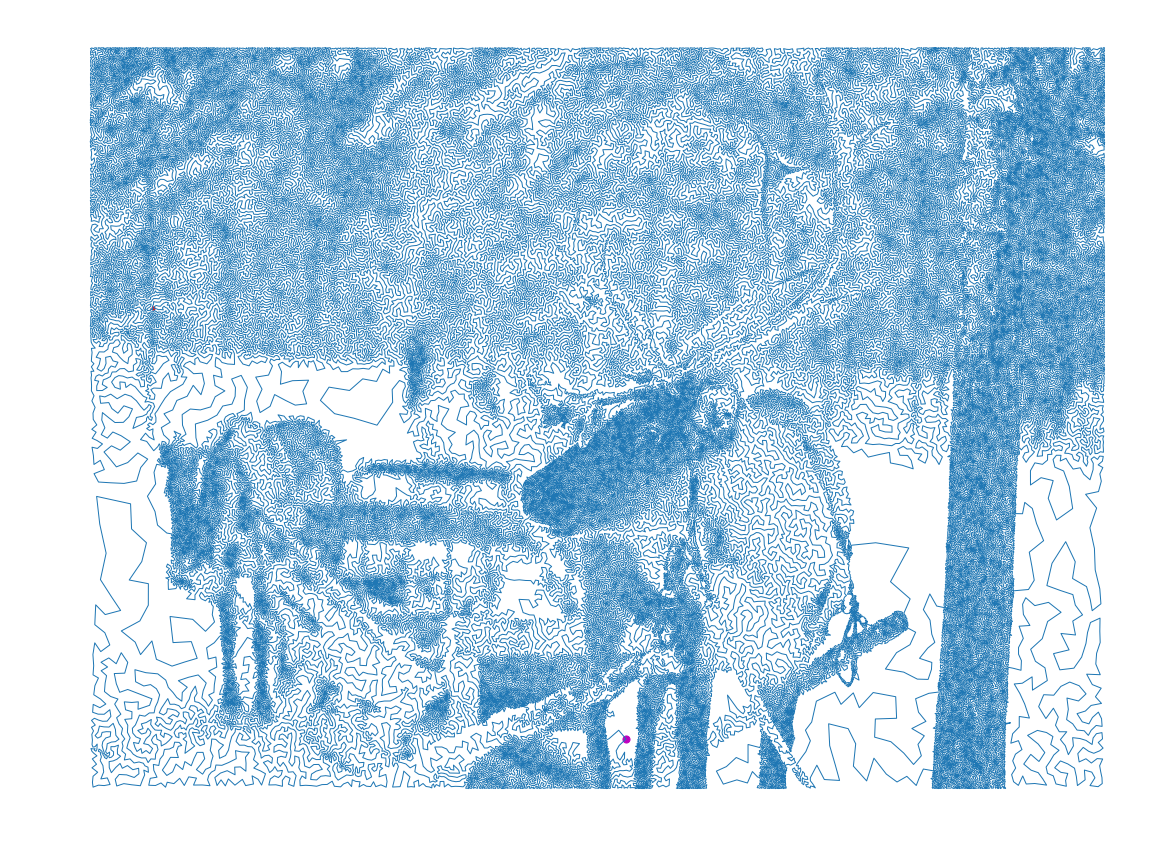

In [235]:
plot_path(path)

In [230]:
@jit('i8[:](i8[:], i8, i8)')
def closest_n(path, num, index):
    if index == 0:
        copy = path[:-1].copy()
    else:
        copy = path[1:-1].copy()
    d = np.array([np.abs(complexes[index] - complexes[i]) for i in copy])
    arg = d.argsort()
    closest_index = np.array([copy[i] for i in arg])[:num+1]
    return closest_index[1:]

def opt_closest(path, num, index):
    perm = closest_n(path, num, index)
    #perm_index = [path.tolist().index(i) for i in perm]
    perm_index = [np.where(path==i)[0][0] for i in perm]
    combs = np.array(list(multiset_permutations(perm)))
    sc1 = score_between(path, 0, len(path)-1)
    sc3 = np.inf
    for comb in combs:
        copy = path.copy()
        for i in range(len(comb)):
            copy[perm_index[i]] = comb[i]
        sc2 = score_between(copy, 0, len(copy)-1)
        if sc1 > sc2:
            if sc3 > sc2:
                sc3 = sc2
                path = copy.copy()
                print(sc2)
                
score_between(path, 0, len(path)-1)

1747784.5163161769

In [ ]:
for i in tqdm(range(len(path))): # 5: 632h, 3: 55h
    opt_closest(path, 4, i)

In [158]:
@jit('i8[:](i8[:], i8, i8)')
def closest_num(path, num, index):
    copy = path.copy()
    d = np.array([np.abs(complexes[index] - complexes[i]) for i in copy])
    arg = d.argsort()
    closest_index = np.array([copy[i] for i in arg])[:num]
    return closest_index


@jit('i8[:](i8[:])', parallel=True)
def find_path(path):
    copy = path[1:].copy()
    half = len(copy)//2
    s1 = np.array([0])
    s2 = np.array([0])
    for i in tqdm(prange(half)):
        if len(copy) > 0:
            c1 = closest_num(copy, 1, s1[-1])
            s1 = np.append(s1, c1)
            copy = np.delete(copy, np.where(copy==c1))
            
            c2 = closest_num(copy, 1, s2[-1])
            s2 = np.append(s2, c2)
            copy = np.delete(copy, np.where(copy==c2))
            if i % 1000 == 0:
                print(len(copy), len(s1), len(s2), len(copy)+len(s1)+len(s2))
        else:
            break
    print(len(copy), len(s1), len(s2))
    return np.concatenate([s1, s2[::-1]])

In [ ]:
path = find_path(path)
score_between(path, 0, len(path)-1)

In [67]:
score_between(path, 0, len(path)-1)

1724934.3273185876

In [287]:
def longest(path):
    #sc_list = - np.array([np.sum(np.abs(np.diff(np.array(complexes[path[i-1: i+2]])))) for i in tqdm(range(1, len(path)-1))])
    sc_list = - np.array([np.sum(np.abs(np.diff(np.array(complexes[path[i-1: i+1]])))) for i in tqdm(range(1, len(path)-1))])
    arg = sc_list.argsort()    
    return arg

@jit('i8[:](i8[:])', parallel=True)
def or_opt(path):
    lon = longest(path)
    print('Initial Score: ', score_between(path, 0, len(path)-1))
    for i in tqdm(lon):
        sc3 = np.inf
        c5 = closest_n(path, 10, path[i])
        for c in c5:
            j = np.where(path==c)[0][0]
            copy = np.delete(path, i)
            copy = np.insert(copy, j, path[i])
            if i >= j:
                sc1 = score_between(path, j-1, i+1)
                sc2 = score_between(copy, j-1, i+1)
            else:
                sc1 = score_between(path, i-1, j+1)
                sc2 = score_between(copy, i-1, j+1)
            if sc1 > sc2:
                if sc3 > sc2:
                    sc3 = sc2
                    path = copy.copy()
                    print(score_between(path, 0, len(path)-1))
    return path

In [ ]:
path = or_opt(path) # 1h 29m
score_between(path, 0, len(path)-1)

In [295]:
eval_path(path)

End: 0 missing:  1515595.022840546
